# Forecasting Water Levels using LSTMs

In [32]:
import IPython.display
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from datetime import timedelta
from wetterdienst import Wetterdienst, Period, Resolution
from wetterdienst.provider.dwd.observation import DwdObservationRequest, \
    DwdObservationPeriod, DwdObservationResolution, DwdObservationParameter, DwdObservationDataset
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
path = 'results/'  # Path for saving the figures later on

## Ensuring that no data is missing (for analysis see, analysis.ipynb

First, look again at any missing or duplicate values in the dataset.

In [34]:
df = pd.read_csv('data/Kaub_Level_Since_2013_updated_v2.csv')
df_original = df
x = df[df.duplicated(['date'])].index
print(f' Show duplicate values, if any: {x.values}')

 Show duplicate values, if any: []


In [35]:
df_index = df.set_index(df['date'])
df_index.index = pd.to_datetime(df_index.index)
dates_original = pd.date_range(start=df['date'].iloc[0], end=df['date'].iloc[-1]).difference(df_index.index)
print('These are the missing dates on the updated data, if any: \n', dates_original.values)
print(f'There are a total of {len(dates_original)} dates missing.')

These are the missing dates on the updated data, if any: 
 []
There are a total of 0 dates missing.


## Add precipitation data from DWD (Deutscher Wetterdienst) using the wetterdienst API

Implement a function in order to get the station ID given a name of a city. This is needed for the later API calls on the DWD data.

In [36]:
def get_station_id(city):
    request = DwdObservationRequest(
        parameter=DwdObservationDataset.PRECIPITATION_MORE,
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    )
    df = request.all().df
    station_string = df[df['name'] == city].station_id
    return int(station_string.iloc[0][1:])

We looked at different available stations along the rhine to use as a additional data. Note: There is no Ludwigshafen in the DWD weather API, so we use Mannheim instead.

In [37]:
ma_id = get_station_id('Mannheim')
frei_id = get_station_id('Freiburg')
rheinau_id = get_station_id('Rheinau-Memprechtshofen')
rheinfelden_id = get_station_id('Rheinfelden')
rheinstetten_id = get_station_id('Rheinstetten')

The next two functions return precipitation data of the DWD given a specified station.

In [38]:
def get_historical_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

def get_recent_data(station_id):
    request = DwdObservationRequest(
        parameter=[
            DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
        ],
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.RECENT
    ).filter_by_station_id(station_id=(station_id, ))

    return request.values.all().df

In [39]:
precipitation_frei_historical = get_historical_data(frei_id)
precipitation_frei_recent = get_recent_data(frei_id)

precipitation_ma_historical = get_historical_data(ma_id)
precipitation_ma_recent= get_recent_data(ma_id)

precipitation_rheinau_historical = get_historical_data(rheinau_id)
precipitation_rheinau_recent = get_recent_data(rheinau_id)

precipitation_rheinfelden_historical = get_historical_data(rheinfelden_id)
precipitation_rheinfelden_recent = get_recent_data(rheinfelden_id)

precipitation_rheinstetten_historical = get_historical_data(rheinstetten_id)
precipitation_rheinstetten_recent = get_recent_data(rheinstetten_id)

In [40]:
precipitation_frei_historical[:365]

,station_id,dataset,parameter,date,value,quality
0,01443,climate_summary,precipitation_height,1874-01-01 00:00:00+00:00,0.0,1.0
1,01443,climate_summary,precipitation_height,1874-01-02 00:00:00+00:00,4.2,1.0
2,01443,climate_summary,precipitation_height,1874-01-03 00:00:00+00:00,2.2,1.0
3,01443,climate_summary,precipitation_height,1874-01-04 00:00:00+00:00,1.1,1.0
4,01443,climate_summary,precipitation_height,1874-01-05 00:00:00+00:00,0.0,1.0
...,...,...,...,...,...,...
360,01443,climate_summary,precipitation_height,1874-12-27 00:00:00+00:00,0.8,1.0
361,01443,climate_summary,precipitation_height,1874-12-28 00:00:00+00:00,0.0,1.0
362,01443,climate_summary,precipitation_height,1874-12-29 00:00:00+00:00,0.0,1.0
363,01443,climate_summary,precipitation_height,1874-12-30 00:00:00+00:00,0.0,1.0


In [41]:
precipitation_frei_recent[365:]

,station_id,dataset,parameter,date,value,quality
365,01443,climate_summary,precipitation_height,2021-06-20 00:00:00+00:00,17.3,3.0
366,01443,climate_summary,precipitation_height,2021-06-21 00:00:00+00:00,3.7,3.0
367,01443,climate_summary,precipitation_height,2021-06-22 00:00:00+00:00,5.5,3.0
368,01443,climate_summary,precipitation_height,2021-06-23 00:00:00+00:00,10.6,3.0
369,01443,climate_summary,precipitation_height,2021-06-24 00:00:00+00:00,6.4,3.0
...,...,...,...,...,...,...
545,01443,climate_summary,precipitation_height,2021-12-17 00:00:00+00:00,0.0,1.0
546,01443,climate_summary,precipitation_height,2021-12-18 00:00:00+00:00,0.0,1.0
547,01443,climate_summary,precipitation_height,2021-12-19 00:00:00+00:00,0.0,1.0
548,01443,climate_summary,precipitation_height,2021-12-20 00:00:00+00:00,0.0,1.0


Now, have a rough look at the historical data:

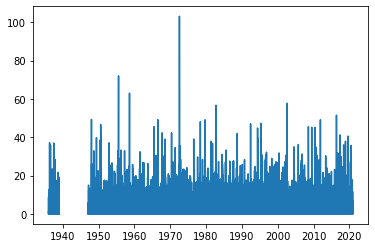

In [42]:
precipitation_ma_historical['value'].loc[:]
plt.plot(precipitation_ma_historical['date'], precipitation_ma_historical['value'].loc[:])

<AxesSubplot:title={'center':'Rheinstetten Historical'}, xlabel='date'>

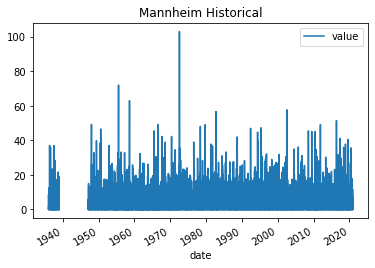

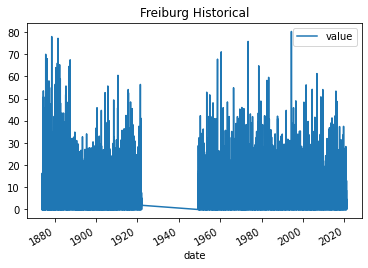

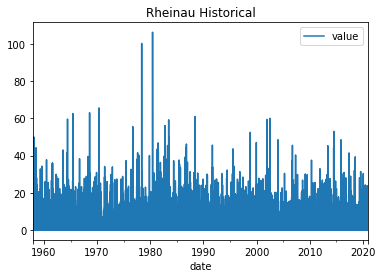

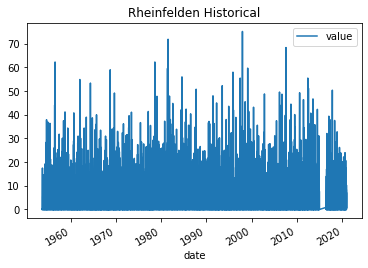

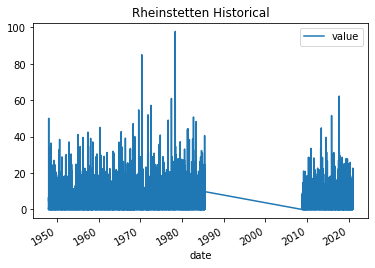

In [43]:
precipitation_ma_historical.plot(x="date", y="value", title='Mannheim Historical')
precipitation_frei_historical.plot(x='date', y='value', title='Freiburg Historical')
precipitation_rheinau_historical.plot(x='date', y='value', title='Rheinau Historical')
precipitation_rheinfelden_historical.plot(x='date', y='value', title='Rheinfelden Historical')
precipitation_rheinstetten_historical.plot(x='date', y='value', title='Rheinstetten Historical')

Based on the above data, there seems to be data missing, but because we have to align the data of the DWD to the data of the rhine water level (kaub), the data missing before 01-01-2013 is of no concern, the data missing after that date is a problem though.

As one can see from all the historical data plots, the start of the historical data differs from station to station. The end of the historical data is however always the same, i.e. the 31-12-2020.

Now, look at the historical precipitation data of Rheinfelden, where there seems to be missing some data, more closely.

<AxesSubplot:title={'center':'Closeup of Rheinfelden Historical'}, xlabel='date'>

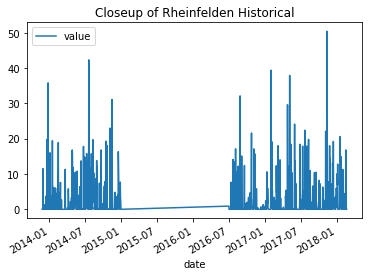

In [44]:
precipitation_rheinfelden_historical.loc[22000:23000].plot(x='date', y='value', title='Closeup of Rheinfelden Historical')

In [45]:
precipitation_rheinfelden_historical.loc[22400:22410]

,station_id,dataset,parameter,date,value,quality
22400,04175,climate_summary,precipitation_height,2014-12-30 00:00:00+00:00,0.6,10.0
22401,04175,climate_summary,precipitation_height,2014-12-31 00:00:00+00:00,0.0,10.0
22402,04175,climate_summary,precipitation_height,2016-07-01 00:00:00+00:00,0.9,10.0
22403,04175,climate_summary,precipitation_height,2016-07-02 00:00:00+00:00,0.0,10.0
22404,04175,climate_summary,precipitation_height,2016-07-03 00:00:00+00:00,0.0,10.0
22405,04175,climate_summary,precipitation_height,2016-07-04 00:00:00+00:00,0.0,10.0
22406,04175,climate_summary,precipitation_height,2016-07-05 00:00:00+00:00,0.0,10.0
22407,04175,climate_summary,precipitation_height,2016-07-06 00:00:00+00:00,0.0,10.0
22408,04175,climate_summary,precipitation_height,2016-07-07 00:00:00+00:00,0.0,10.0
22409,04175,climate_summary,precipitation_height,2016-07-08 00:00:00+00:00,0.0,10.0


Upon closer inspecting the rheinfelden precipitation data, the entirety from 2014 until 2016 is missing. This is of great concern since filling these values with artificially created values would certainly do more harm than having the data included would do good. This is why we decided to discard this data.

<AxesSubplot:title={'center':'Rheinstetten Recent'}, xlabel='date'>

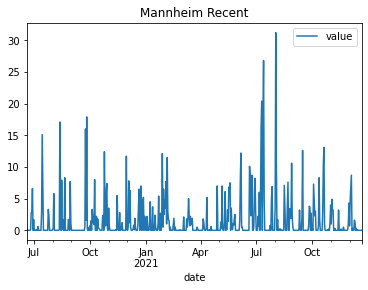

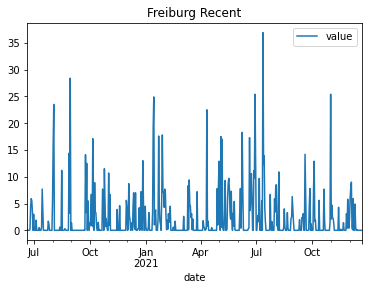

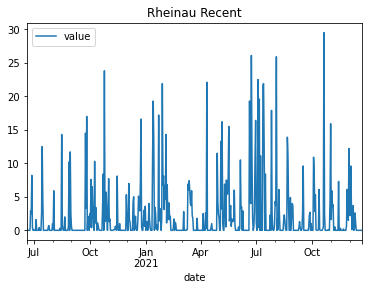

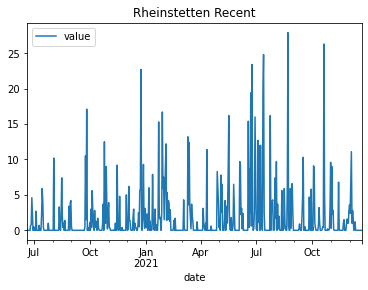

In [46]:
precipitation_ma_recent.plot(x="date", y="value", title='Mannheim Recent')
precipitation_frei_recent.plot(x="date", y="value", title='Freiburg Recent')
precipitation_rheinau_recent.plot(x="date", y="value", title='Rheinau Recent')
precipitation_rheinstetten_recent.plot(x="date", y="value", title='Rheinstetten Recent')

In [47]:
precipitation_frei_recent[:10]

,station_id,dataset,parameter,date,value,quality
0,01443,climate_summary,precipitation_height,2020-06-20 00:00:00+00:00,0.0,3.0
1,01443,climate_summary,precipitation_height,2020-06-21 00:00:00+00:00,0.1,3.0
2,01443,climate_summary,precipitation_height,2020-06-22 00:00:00+00:00,0.0,3.0
3,01443,climate_summary,precipitation_height,2020-06-23 00:00:00+00:00,0.0,3.0
4,01443,climate_summary,precipitation_height,2020-06-24 00:00:00+00:00,0.0,3.0
5,01443,climate_summary,precipitation_height,2020-06-25 00:00:00+00:00,0.2,3.0
6,01443,climate_summary,precipitation_height,2020-06-26 00:00:00+00:00,4.3,3.0
7,01443,climate_summary,precipitation_height,2020-06-27 00:00:00+00:00,5.9,3.0
8,01443,climate_summary,precipitation_height,2020-06-28 00:00:00+00:00,5.5,3.0
9,01443,climate_summary,precipitation_height,2020-06-29 00:00:00+00:00,3.3,3.0


The recent data is in the timespan of [17-07-2020, now], where 'now' is the date before the day this program is run.

In [48]:
assert(len(precipitation_ma_recent) == len(precipitation_frei_recent) == len(precipitation_rheinau_recent) == len(precipitation_rheinstetten_recent))

In [49]:
assert(precipitation_ma_recent['date'].loc[0] == precipitation_frei_recent['date'].loc[0].date() == precipitation_rheinau_recent['date'].loc[0].date() == precipitation_rheinstetten_recent['date'].loc[0].date())

/tmp/ipykernel_330563/1846286331.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  assert(precipitation_ma_recent['date'].loc[0] == precipitation_frei_recent['date'].loc[0].date() == precipitation_rheinau_recent['date'].loc[0].date() == precipitation_rheinstetten_recent['date'].loc[0].date())


## In-depth analysis of missing/duplicate values of DWD data

Put the data in lists for convenience.

In [50]:
historicals = {'Mannheim_historical' : precipitation_ma_historical,
               'Rheinstetten_historical': precipitation_rheinstetten_historical,
               'Freiburg_historical' : precipitation_frei_historical,
               'Rheinau_historical' : precipitation_rheinau_historical}
recents = {'Mannheim_recent' : precipitation_ma_recent,
           'Rheinstetten_recent': precipitation_rheinstetten_recent,
           'Freiburg_recent' : precipitation_frei_recent,
           'Rheinau_recent' : precipitation_rheinau_recent}

total = {}
total.update(recents)
total.update(historicals)

First, have a look at duplicate values, i.e. duplicate dates:

In [51]:
for name, prec in total.items():
    print(f'The {name} dataset has {prec[prec.duplicated(["date"])].value.values} duplicate values.')

The Mannheim_recent dataset has [] duplicate values.
The Rheinstetten_recent dataset has [] duplicate values.
The Freiburg_recent dataset has [] duplicate values.
The Rheinau_recent dataset has [] duplicate values.
The Mannheim_historical dataset has [] duplicate values.
The Rheinstetten_historical dataset has [] duplicate values.
The Freiburg_historical dataset has [] duplicate values.
The Rheinau_historical dataset has [] duplicate values.


As can be seen above, there are no duplicate values by date.

Check that there are no null/NaN values in the data

In [52]:
for name, prec in total.items():
    print(f'The {name} dataset has {len(prec[prec.isna().any(axis=1)].value.values)} null values')

The Mannheim_recent dataset has 0 null values
The Rheinstetten_recent dataset has 0 null values
The Freiburg_recent dataset has 0 null values
The Rheinau_recent dataset has 0 null values
The Mannheim_historical dataset has 3 null values
The Rheinstetten_historical dataset has 4 null values
The Freiburg_historical dataset has 205 null values
The Rheinau_historical dataset has 0 null values


There are some values missing, now show the indices of these null values:

In [58]:
for name, prec in total.items():
    print(f'The {name} dataset has the following null values:\n{prec["date"].loc[prec.isna().any(axis=1)] if len(prec[prec.isna().any(axis=1)].value.values)>0 else "No missing values"}')

The Mannheim_recent dataset has the following null values:
No missing values
The Rheinstetten_recent dataset has the following null values:
No missing values
The Freiburg_recent dataset has the following null values:
No missing values
The Rheinau_recent dataset has the following null values:
No missing values
The Mannheim_historical dataset has the following null values:
1095    1938-12-31 00:00:00+00:00
27122   2018-04-04 00:00:00+00:00
27123   2018-04-05 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]
The Rheinstetten_historical dataset has the following null values:
17256   2018-08-01 00:00:00+00:00
17675   2019-09-24 00:00:00+00:00
17676   2019-09-25 00:00:00+00:00
17678   2019-09-27 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]
The Freiburg_historical dataset has the following null values:
58      1874-02-28 00:00:00+00:00
84      1874-03-26 00:00:00+00:00
177     1874-06-27 00:00:00+00:00
178     1874-06-28 00:00:00+00:00
441     1875-03-18 00:00:00+00:00
          

Now output these missing datapoints, s.t. we know the date.

As can be seen in the above output, only the values in the mannheim historical dataframe at index 27122, 27123 and in the freiburg historical dataframe at index 42767 to 42770 are of relevance, since they are in the relevant timespan. Also, the 4 null values from Rheinstetten are relevant.

We will deal with these data points later on. First, we want to see if there are any dates missing in the data:

In [59]:
for name, prec in historicals.items():
    df1 = prec.set_index(prec['date'])
    df1.index = pd.to_datetime(df1.index)
    dates = pd.date_range(start="2013-1-1 00:00:00+00:00", end='2020-12-31 00:00:00+00:00').difference(df1.index)
    print(f'The {name} dataset has the following missing dates\n{dates.values if len(dates.values)>0 else "No missing dates"}')

The Mannheim_historical dataset has the following missing dates
No missing dates
The Rheinstetten_historical dataset has the following missing dates
No missing dates
The Freiburg_historical dataset has the following missing dates
No missing dates
The Rheinau_historical dataset has the following missing dates
No missing dates


In [60]:
for name, prec in recents.items():
    df1 = prec.set_index(prec['date'])
    df1.index = pd.to_datetime(df1.index)
    dates = pd.date_range(start='2021-1-1 00:00:00+00:00', end='2021-12-18 00:00:00+00:00').difference(df1.index)
    print(f'The {name} dataset has the following missing dates\n{dates.values if len(dates.values)>0 else "No missing dates"}')

The Mannheim_recent dataset has the following missing dates
No missing dates
The Rheinstetten_recent dataset has the following missing dates
No missing dates
The Freiburg_recent dataset has the following missing dates
No missing dates
The Rheinau_recent dataset has the following missing dates
No missing dates


In [61]:
precipitation_ma_recent

,station_id,dataset,parameter,date,value,quality
0,05906,climate_summary,precipitation_height,2020-06-20 00:00:00+00:00,0.3,3.0
1,05906,climate_summary,precipitation_height,2020-06-21 00:00:00+00:00,0.0,3.0
2,05906,climate_summary,precipitation_height,2020-06-22 00:00:00+00:00,0.0,3.0
3,05906,climate_summary,precipitation_height,2020-06-23 00:00:00+00:00,0.0,3.0
4,05906,climate_summary,precipitation_height,2020-06-24 00:00:00+00:00,0.0,3.0
...,...,...,...,...,...,...
545,05906,climate_summary,precipitation_height,2021-12-17 00:00:00+00:00,0.0,1.0
546,05906,climate_summary,precipitation_height,2021-12-18 00:00:00+00:00,0.0,1.0
547,05906,climate_summary,precipitation_height,2021-12-19 00:00:00+00:00,0.0,1.0
548,05906,climate_summary,precipitation_height,2021-12-20 00:00:00+00:00,0.0,1.0


## Preparing the DWD data

Prepare the data to be adjusted into the right range. This is done by cutting the historical df into the range [startdate_kaub_data, end_historical_data] and the recent df to [end_historical_data + 1, end_kaub_data]

In [62]:
precipitation_ma_historical['date'] = pd.to_datetime(precipitation_ma_historical['date'], unit='s').dt.date
precipitation_ma_recent['date'] = pd.to_datetime(precipitation_ma_recent['date'], unit='s').dt.date
precipitation_frei_historical['date'] = pd.to_datetime(precipitation_frei_historical['date'], unit='s').dt.date
precipitation_frei_recent['date'] = pd.to_datetime(precipitation_frei_recent['date'], unit='s').dt.date
precipitation_rheinau_historical['date'] = pd.to_datetime(precipitation_rheinau_historical['date'], unit='s').dt.date
precipitation_rheinau_recent['date'] = pd.to_datetime(precipitation_rheinau_recent['date'], unit='s').dt.date
precipitation_rheinstetten_historical['date'] = pd.to_datetime(precipitation_rheinstetten_historical['date'], unit='s').dt.date
precipitation_rheinstetten_recent['date'] = pd.to_datetime(precipitation_rheinstetten_recent['date'], unit='s').dt.date

In [63]:
startdate = pd.to_datetime(df['date'].iloc[0]).date() # startdate_kaub_data
inter_enddate = pd.to_datetime(precipitation_ma_historical['date'].iloc[-1]).date() # end_historical_data
inter_startdate = inter_enddate + timedelta(days=1) # end_historical_data + 1
enddate = pd.to_datetime(df['date'].iloc[-1]).date() # end_kaub_data

Before we can shift the data to be in the right range, we need to know the amount of shifting that needs to be done since precipitation has a delayed effect on water levels. It may need to be shifted even more for the cities Freiburg or Rheinau, since they are farther away from Ludwigshafen/Mannheim.

In edit_dataframe, we prepare the DWD dataframes to be added to the Kaub data by dropping columns and adding recent to historical values.

In [64]:
def edit_dataframe(prec_historical, prec_recent):
    prec_total = prec_historical.append(prec_recent).reset_index(drop=True)
    prec_total = prec_total.rename({'value':'precipitation_height'}, axis=1)
    prec_total = prec_total.drop(['parameter', 'dataset', 'station_id', 'quality'], axis=1)
    assert(len(prec_total) == len(df))
    prec_total = prec_total.drop('date', axis = 1)
    return prec_total

## Getting the shift right

Next, we provide a function which will help as an analysis for the best shift of the precipitation data in contrast to the Kaub data. This function returns the performances of the different shifts using the spearman correlation coefficient as a metric.

In [65]:
def get_best_shift(nmbr_shifts, df_recent, df_hist):
    totals = []
    for i in range(1, nmbr_shifts+1):
        recent_shift = df_recent.loc[df_recent['date'].between(inter_startdate-timedelta(days=i), enddate-timedelta(days=i), inclusive=True)]
        hist_shift = df_hist.loc[df_hist['date'].between(startdate-timedelta(days=i), inter_enddate-timedelta(days=i), inclusive=True)]
        recent_shift = recent_shift.fillna(method='ffill')
        hist_shift = hist_shift.fillna(method='ffill')
        x = edit_dataframe(hist_shift, recent_shift)
        totals.append(x)

    best = []
    for precipitation in totals:
        cor = precipitation['precipitation_height'].corr(df['level'], method='spearman')
        best.append(cor)
    index, element = max(enumerate(best), key=itemgetter(1))
    return (index, element), best

In [66]:
shift_ma, cor_array_ma = get_best_shift(50, precipitation_ma_recent, precipitation_ma_historical)
shift_frei, cor_array_frei = get_best_shift(50, precipitation_frei_recent, precipitation_frei_historical)
shift_rhei, cor_array_rhei = get_best_shift(50, precipitation_rheinau_recent, precipitation_rheinau_historical)
shift_rheinst, cor_array_rheinst = get_best_shift(50, precipitation_rheinstetten_recent, precipitation_rheinstetten_historical)

/tmp/ipykernel_330563/3256371367.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  recent_shift = df_recent.loc[df_recent['date'].between(inter_startdate-timedelta(days=i), enddate-timedelta(days=i), inclusive=True)]
/tmp/ipykernel_330563/3256371367.py:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  hist_shift = df_hist.loc[df_hist['date'].between(startdate-timedelta(days=i), inter_enddate-timedelta(days=i), inclusive=True)]


In [ ]:
print(f'These are the best shifts for Mannheim {shift_ma}\nFreiburg: {shift_frei}\nRheinau: {shift_rhei}\nRheinstetten:{shift_rheinst}')

In [ ]:
print(len(cor_array_ma), len(cor_array_frei), len(cor_array_rhei), len(cor_array_rheinst))

In [ ]:
plt.plot(np.arange(len(cor_array_ma)), cor_array_ma, label='Mannheim')
plt.plot(np.arange(len(cor_array_frei)), cor_array_frei, label='Freiburg')
plt.plot(np.arange(len(cor_array_rhei)), cor_array_rhei, label='Rheinau')
plt.plot(np.arange(len(cor_array_rheinst)), cor_array_rheinst, label='Rheinstetten')
plt.xlabel('Dataframe shifting in days')
plt.ylabel('Spearman correlation coefficient')
plt.legend()
plt.title('Impact of precipitation on water level')
plt.savefig(path + 'correlation.png')

Another interesting bit is, that for every city, whether it be Mannheim or Freiburg, the highest correlation is at a shift of 4 days. This is particularly interesting, since the distance between Freiburg and Mannheim is 200km. It is hard to get information about the velocity of the Rhine. The SWR says, that the water flows at a velocity of 6kp/h at Mannheim (cf. <a href="https://www.swr.de/wissen/1000-antworten/wissenschaft-und-forschung/1000-antworten-2894.html#:~:text=Steht%20man%20in%20Mannheim%20am,Schneller%20als%20ein%20z%C3%BCgiger%20Fu%C3%9Fg%C3%A4nger">this website</a>). This could be faster or slower for the part of the Rhine between Freiburg and Mannheim depending on various different aspects: River width, channel shape, the volume of water and the gradient of its riverbed.

If we would assume the river to have a constant velocity of 6km/h between Freiburg and Mannheim, then the precipitation in Freiburg should have at least a 200km/6km/h = 33hours delay in contrast to the precipitation in Mannheim. I.e., the highest impact/correlation should be by shifting the data of precipitation in Freiburg by 5 days, when the correlation of precipitation to water levels in Mannheim takes 4 days.

There could be multiple reasons why this is not the case here:
1. The weather stations are sometimes far away, sometimes near by river => The data is noisy, since the weather could be vastly different even when the weather station's distance to the Rhine is only a few kilometres.
2. The Rhine flows a lot faster between Freiburg and Mannheim => Could be the case, but unlikely, since the Rhine would have to flow much faster
3. Different time of recording for the day. A weather station could for example measure its precipitation not until midnight but could stop earlier and could then put the rest of the daily precipitation onto the next day => Also rather unlikely, since I would assume that the stations use the same time period for their measurements nationwide, but definitely statewide.

## Splitting and merging the data

Now we split the data accordingly.

In [ ]:
shift_ma = 0,0
shift_frei = 0,0
shift_rhei = 0,0
shift_rheinst = 0,0

In [ ]:
precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate-timedelta(days=shift_ma[0]), inter_enddate-timedelta(days=shift_ma[0]), inclusive=True)]
precipitation_ma_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(inter_startdate-timedelta(days=shift_ma[0]), enddate-timedelta(days=shift_ma[0]), inclusive=True)]

precipitation_rheinau_historical = precipitation_rheinau_historical.loc[precipitation_rheinau_historical['date'].between(startdate-timedelta(days=shift_rhei[0]), inter_enddate-timedelta(days=shift_rhei[0]), inclusive=True)]
precipitation_rheinau_recent = precipitation_rheinau_recent.loc[precipitation_rheinau_recent['date'].between(inter_startdate-timedelta(days=shift_rhei[0]), enddate-timedelta(days=shift_rhei[0]), inclusive=True)]

precipitation_frei_historical = precipitation_frei_historical.loc[precipitation_frei_historical['date'].between(startdate-timedelta(days=shift_frei[0]), inter_enddate-timedelta(days=shift_frei[0]), inclusive=True)]
precipitation_frei_recent = precipitation_frei_recent.loc[precipitation_frei_recent['date'].between(inter_startdate-timedelta(days=shift_frei[0]), enddate-timedelta(days=shift_frei[0]), inclusive=True)]

precipitation_rheinstetten_historical = precipitation_rheinstetten_historical.loc[precipitation_rheinstetten_historical['date'].between(startdate-timedelta(days=shift_rheinst[0]), inter_enddate-timedelta(days=shift_rheinst[0]), inclusive=True)]
precipitation_rheinstetten_recent = precipitation_rheinstetten_recent.loc[precipitation_rheinstetten_recent['date'].between(inter_startdate-timedelta(days=shift_rheinst[0]), enddate-timedelta(days=shift_rheinst[0]), inclusive=True)]

In [ ]:
assert(len(precipitation_ma_historical == len(precipitation_rheinau_historical)) == len(precipitation_frei_historical) == len(precipitation_rheinstetten_historical))
assert(len(precipitation_ma_recent == len(precipitation_rheinau_recent)) == len(precipitation_frei_recent) == len(precipitation_rheinstetten_recent))

Unfortunately, as seen earlier, there are some null/NaN values in the DWD data. In the following, I will simply interpolate these missing values using ffill. This will propagate the last observed value to it. This may not be the optimal solution for dealing with these two specific missing values, but in the grand scheme of things, when using neural networks, this should not be an issue, especially considering that the Baseline model, which will just predict the t for t+1, is a fairly good prediction (we will see this later).

In [ ]:
precipitation_frei_historical[precipitation_frei_historical.isna().any(axis=1)]

In [ ]:
precipitation_ma_historical[precipitation_ma_historical.isna().any(axis=1)]

In [ ]:
precipitation_rheinstetten_historical[precipitation_rheinstetten_historical.isna().any(axis=1)]

In [ ]:
precipitation_rheinau_historical[precipitation_rheinau_historical.isna().any(axis=1)]

In [ ]:
precipitation_ma_historical = precipitation_ma_historical.fillna(method='ffill')
precipitation_frei_historical = precipitation_frei_historical.fillna(method='ffill')
precipitation_rheinstetten_historical = precipitation_rheinstetten_historical.fillna(method='ffill')

In [ ]:
precipitation_ma = edit_dataframe(precipitation_ma_historical, precipitation_ma_recent)
precipitation_frei = edit_dataframe(precipitation_frei_historical, precipitation_frei_recent)
precipitation_rheinau = edit_dataframe(precipitation_rheinau_historical, precipitation_rheinau_recent)
precipitation_rheinstetten = edit_dataframe(precipitation_rheinstetten_historical, precipitation_rheinstetten_recent)

In [ ]:
df = df.drop('date', axis = 1)

In [ ]:
df['precipitation_ma_height'] = precipitation_ma['precipitation_height']
df['precipitation_frei_height'] = precipitation_frei['precipitation_height']
df['precipitation_rheinau_height'] = precipitation_rheinau['precipitation_height']
df['precipitation_rheinstetten_height'] = precipitation_rheinstetten['precipitation_height']

## Correlation between precipitation and water level

In [ ]:
df['precipitation_ma_height'].corr(df['level'], method='spearman')

In [ ]:
df['precipitation_frei_height'].corr(df['level'], method='spearman')

In [ ]:
df['precipitation_rheinau_height'].corr(df['level'], method='spearman')

In [ ]:
df['precipitation_rheinstetten_height'].corr(df['level'], method='spearman')

In [ ]:
# df = df.drop(['precipitation_ma_height', 'precipitation_frei_height', 'precipitation_rheinau_height', 'precipitation_rheinstetten_height'], axis=1)

In [ ]:
df

## Splitting and Standardizing

Split the data in train-validation-test split: 70:20:10 ratio. In order to get a more accurate overall presentation of the data, i.e. to guarantee that the data is i.i.d, one could randomly shuffle the data. This generally leads to lower variance and less overfitting when training a neural network. I did not decide to do this however, since this would badly influence the performance of the model because the data points are time dependent on each other.

Not shuffling the data leads to another problem: The distributions of the training/validation/test-dataset may be different. This can mean, that the model is fitting nicely on the training data, but is having trouble generalizing its "findings" onto the test dataset, since the test dataset is from another distribution. This could lead to underfitting.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [ ]:
num_features

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

In [ ]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

In [ ]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

As already hinted at earlier, the distribution of the data seems to differ a bit, while the train mean is 206, the test mean is now 230. Furthermore, the standard deviation of the training data is 103, while the std of the test data is 127. This can lead to a lower performance of the network on the test data.

Test, if split was successful.

In [ ]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

Maybe use moving averages instead of average in the next cell since the model shouldn't have access to future values in the training set when training?!

In [ ]:
pre_transformation = train_df

Since there are many outliers on the higher end, we use the RobustScaler instead of the StandardScaler.

In [ ]:
scaler = RobustScaler().fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [ ]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [ ]:
train_df.describe()

In [ ]:
pre_transformation

In [ ]:
train_df

In [ ]:
pre_transformation['precipitation_rheinstetten_height'].plot()


In [ ]:
train_df['precipitation_rheinstetten_height'].plot()

In this exemplary plot, one can see that the scaling of data has worked.

In [ ]:
train_df.plot()

In [ ]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the (test) data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')


In [ ]:
test_df.describe()

## Initializing a class for training and evaluating the networks

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, name, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    plt.suptitle('Example predictions of ' + name + ' model')
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.title('Predictions vs true value')
        plt.ylabel(f'{plot_col} (standardized)')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')
    plt.savefig(path + name + '_example.png')
WindowGenerator.plot = plot


In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

Next, the step window is defined. In our task, we will predict 7 days at once.

In [ ]:
single_step_window = WindowGenerator(
    input_width=7, label_width=7, shift=7,
    label_columns=['level'])
single_step_window

single_step_window


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


## 1. Model: Baseline

The baseline model predicts always the water level of the last week as the next week.

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [ ]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [ ]:
single_step_window.plot('baseline', baseline)

In the plot the predictions and the actual data (truth values) are shown. One can nicely see, that for our task, the model takes it last observation at timestep t, and predicts with it the next step at t+7.

## 2. Model: LSTM

The LSTM model will use early stopping, i.e. it stops when the model does not notably decrease its loss function, evaluated on the validation loss to be precise. This will speed up training and also, as a sideffect, can actually have a positive effect on the test data. This way, it may not overfit on the validation data.

In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(18, return_sequences=False),
    tf.keras.layers.Dense(7*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([7, num_features])
])


In [ ]:
history = compile_and_fit(lstm_model, single_step_window)
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



In [ ]:
lstm_model.summary()

We decided for a fairly shallow and small LSTM model, otherwise, there would be too many parameters to optimize for the amount of data that we have.

In [ ]:
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Test')
plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(path + 'loss_lstm.png')

In [ ]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation')
plt.plot(history.history['mean_absolute_error'], label='Test')
plt.title('Error per Epoch')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(path + 'error_epoch_lstm.png')

Interestingly, the model is not really taking many epochs to optimize itself on the data. After already 4 epochs it only marginally decreases its loss / the mean absolute error.

In [ ]:
single_step_window.plot('LSTM', lstm_model)

In [ ]:
plt.ylabel('mean_absolute_error (standardized)')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
plt.title('LSTM Error')
barlist[0].set_color('orange')
barlist[1].set_color('g')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig(path + 'error_lstm.png')

## 3. Model: Feed Forward Network

In [ ]:
ffn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(256, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(7*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([7, num_features])
])


In [ ]:
history = compile_and_fit(ffn_model, single_step_window)
IPython.display.clear_output()
train_performance['Dense'] = ffn_model.evaluate(single_step_window.train)
val_performance['Dense'] = ffn_model.evaluate(single_step_window.val)
performance['Dense'] = ffn_model.evaluate(single_step_window.test, verbose=0)



In [ ]:
ffn_model.summary()

In [ ]:
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Test')
plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(path + 'loss_ffn.png')

In [ ]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation')
plt.plot(history.history['mean_absolute_error'], label='Test')
plt.title('Error per Epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(path + 'error_epoch_ffn.png')

In [ ]:
single_step_window.plot('FFN', ffn_model)

In [ ]:
plt.title('Error of Feed Forward Network')
plt.ylabel('Mean absolute error (standardized)')
x = np.arange(3)
dense_performance = [train_performance['Dense'][1], val_performance['Dense'][1], performance['Dense'][1]]
barlist = plt.bar(x, dense_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')
plt.savefig(path + 'error_ffn.png')

## 4. Autoregressive LSTM

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)


In [ ]:
feedback_model = FeedBack(units=32, out_steps=7)


In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(single_step_window.example[0])
prediction.shape


In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call


In [ ]:
history = compile_and_fit(feedback_model, single_step_window)

IPython.display.clear_output()

train_performance['AR'] = feedback_model.evaluate(single_step_window.train)
val_performance['AR'] = feedback_model.evaluate(single_step_window.val)
performance['AR'] = feedback_model.evaluate(single_step_window.test, verbose=0)
single_step_window.plot('AR', feedback_model)

In [ ]:
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Test')
plt.title('Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig(path + 'loss_ar.png')

In [ ]:
plt.plot(history.history['val_mean_absolute_error'], label='Validation')
plt.plot(history.history['mean_absolute_error'], label='Test')
plt.title('Error per Epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(path + 'error_epoch_ar.png')

## Performance of all models in comparison

In [ ]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name}: {value[1]:0.4f}')


In [ ]:
print(f"Baseline: Train: {train_performance['Baseline'][1]:.3f}, Validation: {val_performance['Baseline'][1]:.3f}, Test: {performance['Baseline'][1]:.2f}")
print(f"LSTM: Train: {train_performance['LSTM'][1]:.3f}, Validation: {val_performance['LSTM'][1]:.3f}, Test: {performance['LSTM'][1]:.3f}")
print(f"Dense: Train: {train_performance['Dense'][1]:.3f}, Validation: {val_performance['Dense'][1]:.3f}, Test: {performance['Dense'][1]:.3f}")
print(f"AR: Train: {train_performance['AR'][1]:.3f}, Validation: {val_performance['AR'][1]:.3f}, Test: {performance['AR'][1]:.3f}")

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Mean absolute error (standardized)')
plt.bar(x - 0.20, val_mae, width, label='Validation')
plt.bar(x + 0.20, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.title('Performances in comparison')
_ = plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig(path + 'comparison_neural.png')


## A comparable Sarima model

We are also going to make a short and basic Sarima model. It should be noted, that there is definitely more performance possible than is being shown here.

In [ ]:
df = df_original

In [ ]:
df.set_index('date', inplace=True)

Augmented Dickey-Fuller test, to see if there is a unit root present in the timeseries, which can cause problems for statistical inferences.

In [ ]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_original['level'])

To make the Sarima model somehow comparable to the neural networks we've implemented above, we chose to make a 90/10 train/test split, since the neural networks also uses 90 percent for training (technically, it uses only 70% for training and uses 20% for validation, i.e. to tune the hyperparameters on it).

We then standardize the data using the RobustScaler, as it was for the neural networks.

In [ ]:
train_df = df[:int(len(df)*0.9)]
test_df = df[int(0.9*len(df)):]

In [ ]:
assert(len(train_df) + len(test_df) == len(df))

In [ ]:
print(len(train_df), len(test_df))

In [ ]:
scaler = RobustScaler().fit(train_df.values)
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

In [ ]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [ ]:
train_df

While Sarima and neural models have the same task and also just try to approximate a function as well as possible, the technicalities make it not as easy comparable to one another as they are comparable in their own space.

This is why we decide to train Sarima the following to compare it to the neural models:
1. Use auto arima on the train data to get the best parameters for this set of data. These parameters are then used as an approximation of the best parameters for Sarima throughout all fitted Sarimas, because using auto_arima on every single data point that later is added would cause significant computation time that likely is overkill)
2. Then predict the next seven days (this would be the start of the test data) and calculate MAE.
3. Now, fit Sarima again on the original train data + 1 of the test data and predict the next seven days after train_data+1
4. Repeat step 3 until there's no data left in the test data.

One could argue that this is also suboptimal because Sarima then has an advantage when predicting the last few weeks of the test dataset because it has the training

In [ ]:
arima_model = auto_arima(train_df['level'], m=7, trace=True)

In [ ]:
arima_model.summary()

In [ ]:
predictions = pd.DataFrame(arima_model.predict(n_periods=7), index=test_df[:7].index)
prediction.columns = ['Prediction']

In [ ]:
predictions

In [ ]:
ax = plt.axes()
ax.plot(train_df[len(train_df)-50:], label='Train')
ax.plot(predictions, label='Predictions/yhats')
ax.plot(test_df[:7], label='Test')
ax.legend()
ax.set_ylabel('Water level (standardized)')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.savefig(path + 'sarima_prediction.png')

In [ ]:
def mae(yhats, y):
    total_mae = 0
    for predictions, truth in zip(yhats, y):
        total_mae += abs(predictions-float(truth))
    return total_mae / len(yhats)

In [ ]:
def train_sarima(df):
    order = (2,1,3)
    seasonal_order = (0,0,0,7)
    total_error = 0
    i = 0
    while i < len(df[int(len(df)*0.9):]) - 7:
        current_train_df = df[:int(len(df)*0.9)+i]
        current_test_df = df[int(len(df)*0.9)+i:]
        scaler = RobustScaler().fit(current_train_df.values)
        current_train_df.values[:] = scaler.transform(current_train_df)
        current_test_df.values[:] = scaler.transform(current_test_df)
        model = SARIMAX(current_train_df['level'], order=order, seasonal_order=seasonal_order, enforce_stationarity=True)
        model_fit = model.fit(maxiter=200, disp=False)
        yhats = model_fit.get_forecast(steps=7)
        total_error += mae(yhats.se_mean, current_test_df[:7]['level'])
        i += 1
    return total_error / i
;

In [ ]:
#df['date'] = pd.to_datetime(df['date'])
#df.set_index('date', inplace=True)

In [ ]:
df

The next cell can take quite some time.

In [ ]:
mae = train_sarima(df)
; # hides output

In [ ]:
performance['Sarima'] = [0, mae]

In [ ]:
x = np.arange(len(performance))
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
test_mae = [v[metric_index] for v in performance.values()]
plt.ylabel('Mean absolute error (standardized)')
plt.bar(x + 0.20, test_mae, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.title('Mean Absolute error in comparison')
_ = plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig(path + 'comparison_every_model.png')

One can see that the Sarima model performs way worse than any other neural model. In fact, it even is unable to predict better than the baseline model, which basically just predicts the last week as a water level for the upcoming week.